# Raster Plot for Single Unit in Anterior Pretectal Nucleus

This notebook demonstrates how to create a raster plot for a specific unit (cluster 722) aligned to feedback times, with trials sorted by correct/incorrect outcome.

In [6]:
# Import required libraries
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
from brainbox.singlecell import bin_spikes
from brainbox.task.trials import find_trial_ids
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Initialize ONE API and Atlas
one = ONE()
ba = AllenAtlas()

# Set probe insertion ID
pid = 'c4f6665f-8be5-476b-a6e8-d81eeae9279d'

# Get experiment ID from probe insertion
eid, probe = one.pid2eid(pid)

In [8]:
# Load spike sorting data
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Select our cluster of interest
cluster_id = 722
spike_idx = np.isin(spikes.clusters, cluster_id)

# Print cluster information
print(f"Cluster {cluster_id} information:")
print(f"Brain region: {clusters['acronym'][cluster_id]}")
print(f"Depth: {clusters['depths'][cluster_id]:.2f} µm")

Cluster 722 information:
Brain region: APN
Depth: 1100.00 µm


In [9]:
# Load trials data
trials = one.load_object(eid, 'trials')

# Sort trials by choice (correct vs incorrect)
trial_idx, dividers = find_trial_ids(trials, sort='choice')
incorrect_trial_idx = trial_idx[0:dividers[0]]  # First group is incorrect trials
correct_trial_idx = trial_idx[dividers[0]:]     # Second group is correct trials

# Reorder trials to have incorrect trials at the top
trial_idx_reordered = np.concatenate([incorrect_trial_idx, correct_trial_idx])

# Print trial information
print(f"Total trials: {len(trial_idx)}")
print(f"Incorrect trials: {len(incorrect_trial_idx)}")
print(f"Correct trials: {len(correct_trial_idx)}")

Total trials: 434
Incorrect trials: 343
Correct trials: 91


In [10]:
# Set parameters for the raster plot
pre_stim = 0.4  # Time before feedback (in seconds)
post_stim = 1.0  # Time after feedback (in seconds)
bin_size = 0.01  # Temporal resolution for raster

# Create raster data using reordered trials
raster, t = bin_spikes(spikes['times'][spike_idx], 
                       trials['feedback_times'][trial_idx_reordered],
                       pre_time=pre_stim,
                       post_time=post_stim,
                       bin_size=bin_size)

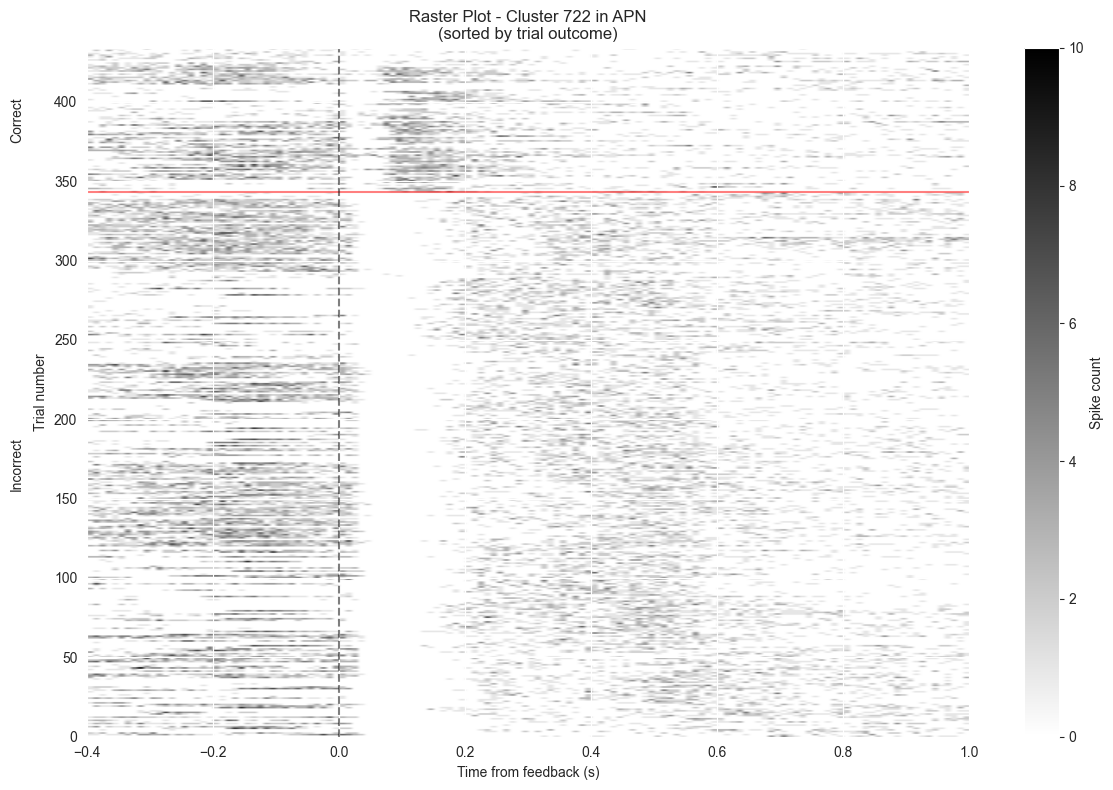

In [11]:
# Create the raster plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot raster
plt.imshow(raster,
          aspect='auto',
          extent=[-pre_stim, post_stim, 0, len(trial_idx_reordered)],
          cmap='binary',
          origin='lower')

# Add separator line between incorrect and correct trials
plt.axhline(y=len(incorrect_trial_idx), color='r', linestyle='-', alpha=0.5)

# Add text labels for trial types
plt.text(-pre_stim - 0.1, len(incorrect_trial_idx)/2, 'Incorrect', 
         rotation=90, verticalalignment='center', horizontalalignment='right')
plt.text(-pre_stim - 0.1, len(incorrect_trial_idx) + len(correct_trial_idx)/2, 'Correct',
         rotation=90, verticalalignment='center', horizontalalignment='right')

# Add vertical line at feedback time
plt.axvline(0, color='k', linestyle='--', alpha=0.5)

# Labels and title
plt.xlabel('Time from feedback (s)')
plt.ylabel('Trial number')
plt.title(f'Raster Plot - Cluster {cluster_id} in {clusters["acronym"][cluster_id]}\n(sorted by trial outcome)')

# Add colorbar
plt.colorbar(label='Spike count')

plt.tight_layout()
plt.show()